In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

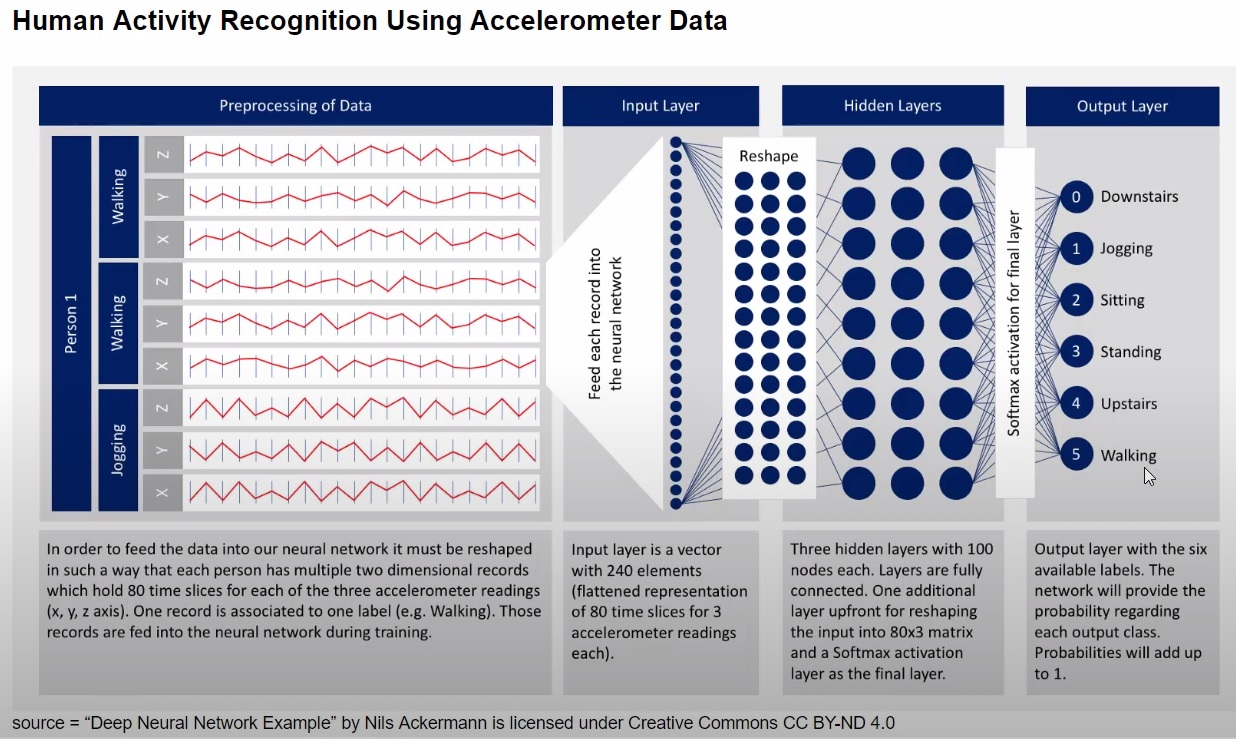

In [10]:
image1=image.load_img('data/humandata.jpg')
image1

raw_about dataset

See readme.txt for information about the WISDM Lab, rights,
and other general information.

Associated tasks: classification
Number of examples: 1,098,207
Number of attributes: 6
Missing attribute values: None
Class distribution: {
	Walking -> 424,400 -> 38.6%,
	Jogging -> 342,177 -> 31.2%,
	Upstairs -> 122,869 -> 11.2%,
	Downstairs -> 100,427 -> 9.1%,
	Sitting -> 59,939 -> 5.5%,
	Standing -> 48,395 -> 4.4% }

raw.txt follows this format:
[user],[activity],[timestamp],[x-acceleration],[y-accel],[z-accel];

This line is a representative example:
33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;

Sampling rate: 
20Hz (1 sample every 50ms)

Fields:
*user
	nominal, 1..36

*activity
	nominal, {
		Walking
		Jogging
		Sitting
		Standing
		Upstairs
		Downstairs }

*timestamp
	numeric, generally the phone's uptime in nanoseconds
		(In future datasets this will be miliseconds
		since unix epoch.)

*x-acceleration
	numeric, floating-point values between -20 .. 20
		The acceleration in the x direction as measured
		by the android phone's accelerometer. 
		A value of 10 = 1g = 9.81 m/s^2, and
		0 = no acceleration.
		The acceleration recorded includes gravitational
		acceleration toward the center of the Earth, so
		that when the phone is at rest on a flat surface
		the vertical axis will register +-10. 

*y-accel
	numeric, see x-acceleration

*z-accel
        numeric, see x-acceleration

###  preprocess the file (그냥열면 알열림)

In [11]:
data=pd.read_csv('data/humandata.csv')

ParserError: Error tokenizing data. C error: Expected 6 fields in line 134634, saw 11


In [14]:
file=open('data/humandata.csv')
lines=file.readlines()
processList=[]
for i,line in enumerate(lines):
    try:
        line=line.split(',')
        last=line[5].split(';')[0]
        last=last.strip()
        if last == '':
            break;
        temp=[line[0],line[1],line[2],line[3],line[4],last]
        processList.append(temp)
    except:
        print('Error at line number:',i)

Error at line number: 281873
Error at line number: 281874
Error at line number: 281875


In [15]:
processList

[['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286'],
 ['33', 'Jogging', '49106062271000', '5.012288', '11.264028', '0.95342433'],
 ['33', 'Jogging', '49106112167000', '4.903325', '10.882658', '-0.08172209'],
 ['33', 'Jogging', '49106222305000', '-0.61291564', '18.496431', '3.0237172'],
 ['33', 'Jogging', '49106332290000', '-1.1849703', '12.108489', '7.205164'],
 ['33', 'Jogging', '49106442306000', '1.3756552', '-2.4925237', '-6.510526'],
 ['33', 'Jogging', '49106542312000', '-0.61291564', '10.56939', '5.706926'],
 ['33', 'Jogging', '49106652389000', '-0.50395286', '13.947236', '7.0553403'],
 ['33', 'Jogging', '49106762313000', '-8.430995', '11.413852', '5.134871'],
 ['33', 'Jogging', '49106872299000', '0.95342433', '1.3756552', '1.6480621'],
 ['33', 'Jogging', '49106982315000', '-8.19945', '19.57244', '2.7240696'],
 ['33', 'Jogging', '49107092330000', '1.4165162', '5.7886477', '2.982856'],
 ['33', 'Jogging', '49107202316000', '-1.879608', '-2.982856', '-0.2996

In [16]:
columns=['user','activity','time','x','y','z']

In [17]:
data=pd.DataFrame(data=processList,columns=columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [20]:
data.shape

(343416, 6)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user      343416 non-null  object
 1   activity  343416 non-null  object
 2   time      343416 non-null  object
 3   x         343416 non-null  object
 4   y         343416 non-null  object
 5   z         343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


In [23]:
data.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [24]:
data['activity'].value_counts()
#highly unbalanced

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

### balance the data

In [25]:
data['x']=data['x'].astype('float')
data['y']=data['y'].astype('float')
data['z']=data['z'].astype('float')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


In [30]:
activities = data['activity'].value_counts().index
Fs=20

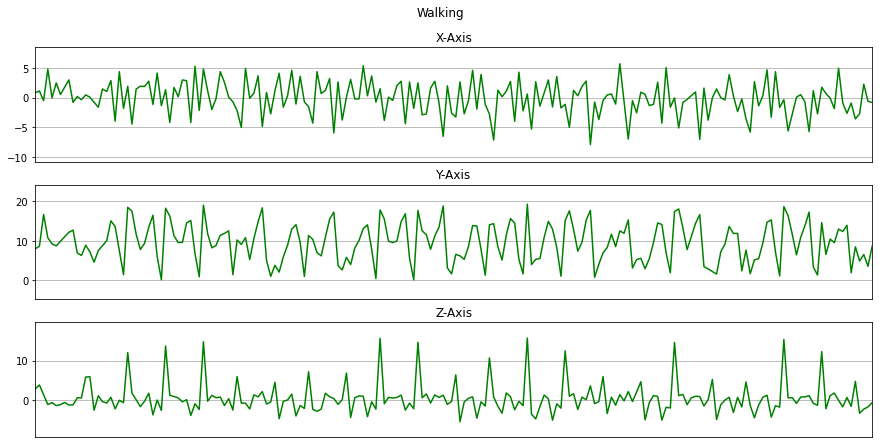

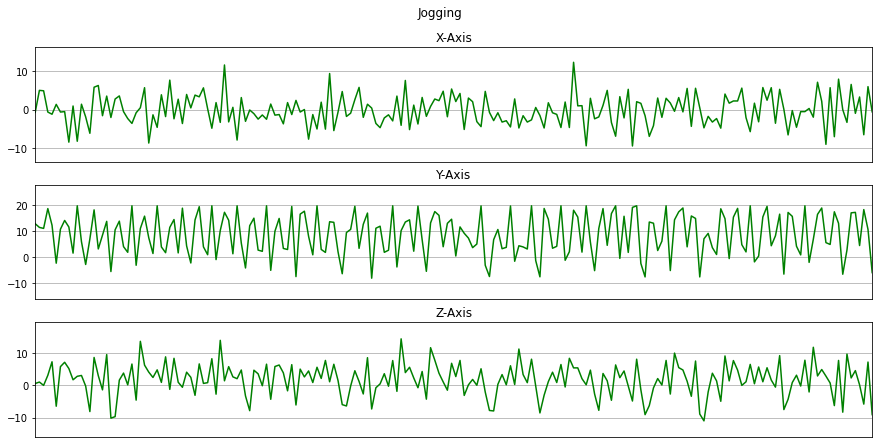

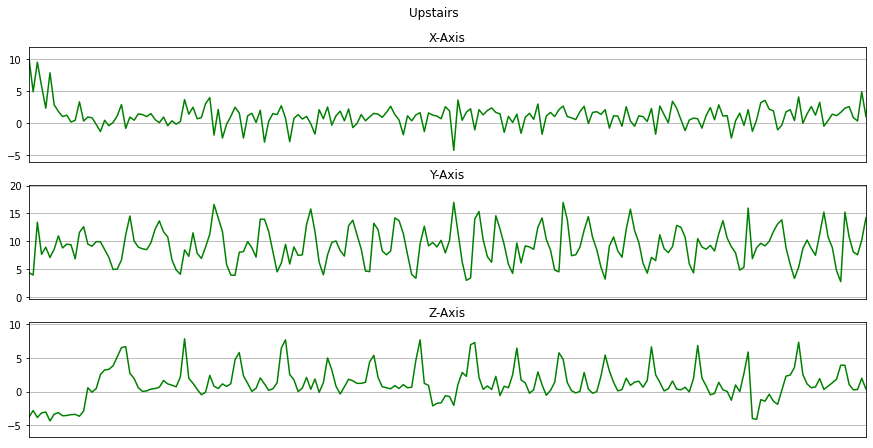

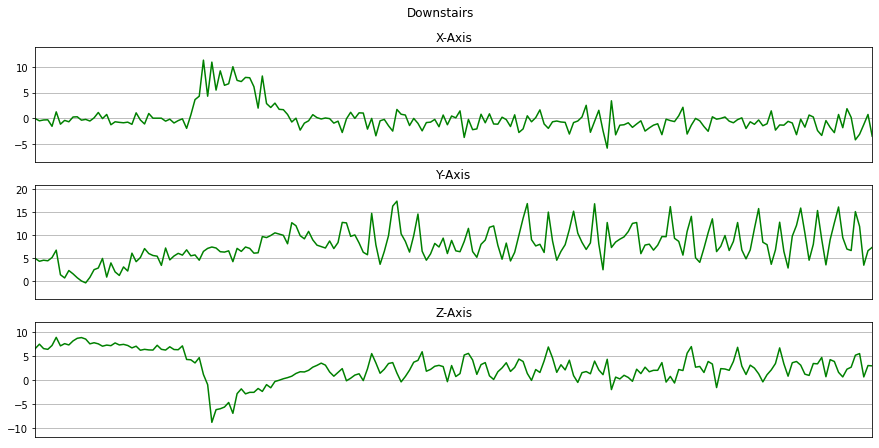

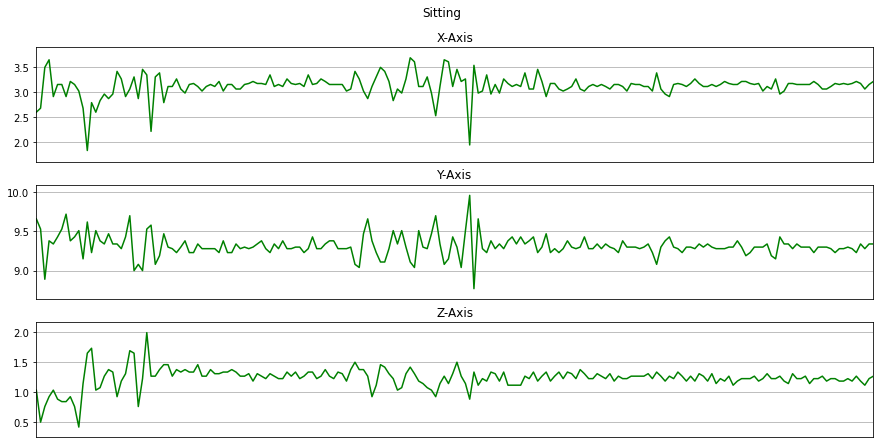

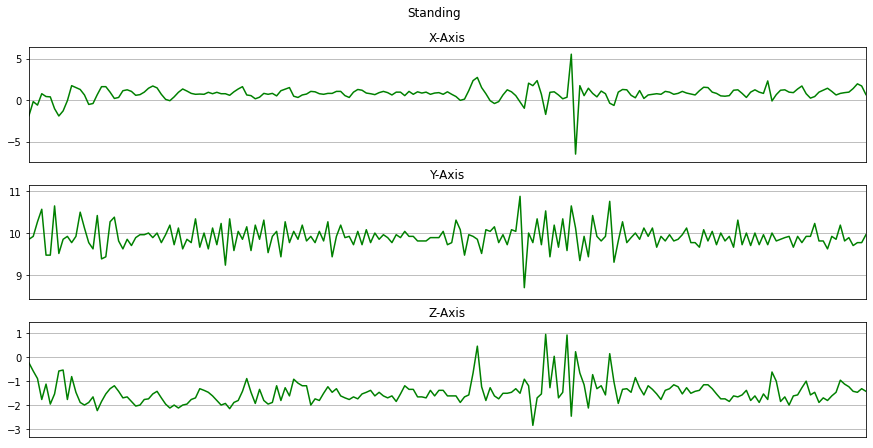

In [31]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [32]:
df=data.drop(['user','time'],axis=1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [33]:
df['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [68]:
Walking=df[df['activity']=='Walking'].head(3555).copy()
Jogging=df[df['activity']=='Jogging'].head(3555).copy()
Upstairs=df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs=df[df['activity']=='Downstairs'].head(3555).copy()
Sitting=df[df['activity']=='Sitting'].head(3555).copy()
Standing=df[df['activity']=='Standing'].copy()

In [69]:
Walking

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638
...,...,...,...,...
10896,Walking,0.190685,7.436710,-0.762740
10897,Walking,4.140586,8.580819,-0.612916
10898,Walking,6.782933,11.345750,-0.422231
10899,Walking,1.838747,12.367276,-1.375655


In [38]:
balanced_data=pd.DataFrame()
balanced_data=balanced_data.append([Walking,Jogging,Upstairs,Downstairs,Sitting,Standing])

In [39]:
balanced_data.shape

(21330, 4)

In [40]:
balanced_data['activity'].value_counts()

Walking       3555
Sitting       3555
Downstairs    3555
Jogging       3555
Standing      3555
Upstairs      3555
Name: activity, dtype: int64

In [41]:
balanced_data.head()

,activity,x,y,z
597,Walking,0.844462,8.008764,2.792171
598,Walking,1.116869,8.621680,3.786457
599,Walking,-0.503953,16.657684,1.307553
600,Walking,4.794363,10.760075,-1.184970
601,Walking,-0.040861,9.234595,-0.694638


In [43]:
label=LabelEncoder()
balanced_data['label']=label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [44]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

### standardization

In [47]:
x=balanced_data[['x','y','z']]
y=balanced_data['label']

In [46]:
scaler=StandardScaler()
x=scaler.fit_transform(x)
x_scale=pd.DataFrame(data=x,columns=['x','y','z'])
x_scale['label']=y.values
x_scale

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


### frame preparation

In [49]:
import scipy.stats as stats

In [50]:
Fs=20
frame_size=Fs*4
hop_size=Fs*2

In [51]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [53]:
x, y = get_frames(x_scale, frame_size, hop_size)

In [70]:
x.shape, y.shape

((532, 80, 3), (532,))

In [75]:
(3555*6-80)/40

531.25

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

In [58]:
x_train.shape, x_test.shape

((425, 80, 3), (107, 80, 3))

In [59]:
x_train = x_train.reshape(425, 80, 3, 1)
x_test = x_test.reshape(107, 80, 3, 1)

### 2D cnn model

In [60]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = x_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [61]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [62]:
history = model.fit(x_train, y_train, epochs = 10, validation_data= (x_test, y_test), verbose=1)

Train on 425 samples, validate on 107 samples
Epoch 1/10
425/425 [==============================] - 1s 2ms/sample - loss: 1.6199 - accuracy: 0.2565 - val_loss: 1.3160 - val_accuracy: 0.3738
Epoch 2/10
425/425 [==============================] - 0s 216us/sample - loss: 1.2200 - accuracy: 0.4682 - val_loss: 0.9622 - val_accuracy: 0.7290
Epoch 3/10
425/425 [==============================] - 0s 202us/sample - loss: 0.9416 - accuracy: 0.6494 - val_loss: 0.6802 - val_accuracy: 0.8037
Epoch 4/10
425/425 [==============================] - 0s 202us/sample - loss: 0.7684 - accuracy: 0.7553 - val_loss: 0.5077 - val_accuracy: 0.8598
Epoch 5/10
425/425 [==============================] - 0s 199us/sample - loss: 0.5707 - accuracy: 0.8376 - val_loss: 0.3952 - val_accuracy: 0.8598
Epoch 6/10
425/425 [==============================] - 0s 202us/sample - loss: 0.4754 - accuracy: 0.8659 - val_loss: 0.3142 - val_accuracy: 0.8972
Epoch 7/10
425/425 [==============================] - 0s 199us/sample - loss: 0.

In [63]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

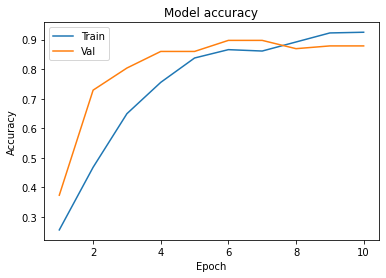

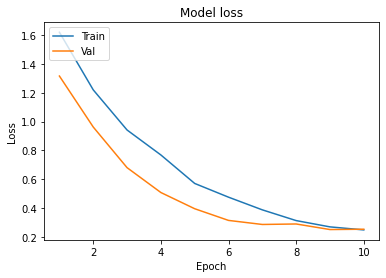

In [64]:
plot_learningCurve(history, 10)

In [65]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [66]:
y_pred = model.predict_classes(x_test)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

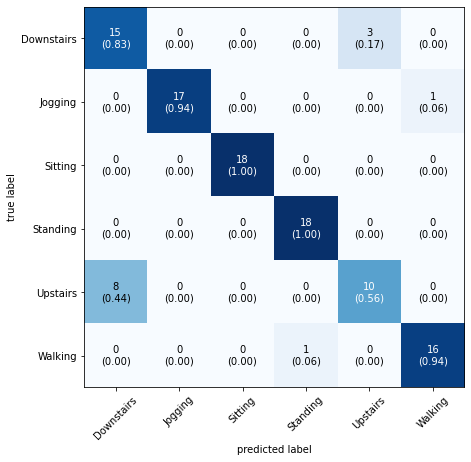

In [67]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))